In [1]:
import matplotlib.pyplot as plt
import subprocess
import re

In [21]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

# pub / sub Throughput

In [2]:
throughput_repeat = 100000
n_pub = 4
n_sub = 1
n_channel = 4

In [6]:
instance = "35.189.139.61 " #instance-1 # producer
broker = "34.84.41.232" #broker
user = "jeffrey"

#CLOA
batcmd=f"ssh {user}@{instance} ./bench {broker} 4242 {throughput_repeat} {n_pub} {n_sub} {n_channel}"
result = subprocess.check_output(batcmd, shell=True, text = True)
result = result.strip()

result_ls = result.split('rps')
pub_throughput = result_ls[0].split(' ')[-1]
sub_throughput = result_ls[1].split(' ')[-1]
cloa_throughput = list(map(int , [pub_throughput, sub_throughput]))

cloa_throughput

In [5]:
# Redis
batcmd=f"ssh {user}@{instance} ./bench --host {broker} --port 6379 {throughput_repeat} --pub {n_pub} --sub {n_sub} --channel {n_channel}"
result = subprocess.check_output(batcmd, shell=True, text = True)
result = result.strip()

result_ls = result.split('rps')
pub_throughput = result_ls[0].split(' ')[-1]
sub_throughput = result_ls[1].split(' ')[-1]
redis_throughput = list(map(int,[pub_throughput, sub_throughput]))

CalledProcessError: Command 'ssh jeffrey@35.213.84.87 ./bench --host 34.84.41.232 --port 6379 100000 --pub 4 --sub 1 --channel 4' returned non-zero exit status 126.

In [7]:
redis_throughput

[581606, 572860]

In [8]:
# Redis-C
batcmd=f"ssh {user}@{instance} ./new_bench --host {broker} --port 5000 {throughput_repeat} --pub {n_pub} --sub {n_sub} --channel {n_channel}"
result = subprocess.check_output(batcmd, shell=True, text = True)
result = result.strip()

result_ls = result.split('rps')
pub_throughput = result_ls[0].split(' ')[-1]
sub_throughput = result_ls[1].split(' ')[-1]
redis_c_throughput = list(map(int,[pub_throughput, sub_throughput]))

In [9]:
redis_c_throughput

[801603, 719101]

In [10]:
# new Redis-C
batcmd=f"ssh {user}@{instance} ./new_bench --host {broker}"
result = subprocess.check_output(batcmd, shell=True, text = True)
result = result.strip()

result_ls = result.split('rps')
pub_throughput = result_ls[0].split(' ')[-1]
sub_throughput = result_ls[1].split(' ')[-1]
new_cloa_throughput = list(map(int,[pub_throughput, sub_throughput]))

In [11]:
new_cloa_throughput

[723327, 688764]

In [12]:
import re

In [13]:
#KAFKA
batcmd=f"ssh {user}@{instance} kafka_2.12-2.3.0/bin/kafka-producer-perf-test.sh --topic test --num-records 5000000 --record-size 10 --throughput -1 --producer-props acks=1 bootstrap.servers=testbroker:9092 buffer.memory=67108864 batch.size=6400"
result = subprocess.check_output(batcmd, shell=True, text = True)
result = result.strip()

res = re.findall("(\w+.\w+) records/sec", result)
pub_throughput = float(res[-1])

batcmd=f"ssh {user}@{instance} kafka_2.12-2.3.0/bin/kafka-consumer-perf-test.sh --broker-list testbroker:9092 --messages 50000000 --topic test --threads 1"
result = subprocess.check_output(batcmd, shell=True, text = True)
result = result.strip()
sub_throughput = float(result.split('\n')[-1].split(',')[5])

kafka_throughput = [pub_throughput, sub_throughput]

kafka_throughput

[851353.652307, 1845622.212]

## Get / Set Throughput

# Redis SET
batcmd=f"ssh {user}@{instance} ./redis-benchmark -h {broker} -t set"
result = subprocess.check_output(batcmd, shell=True, text = True)
result = result.strip()
result

p = re.compile(r'(\d+\.\d+) requests per second')

m = p.search(result)
redis_set_throughput = [float(m.group(1))]

# Redis-c SET
batcmd=f"ssh {user}@{instance} ./redis-benchmark -h {broker} -p 5000 -t set"
result = subprocess.check_output(batcmd, shell=True, text = True)
result = result.strip()
result

p = re.compile(r'(\d+\.\d+) requests per second')

m = p.search(result)
redis_c_set_throughput = [float(m.group(1))]

# Redis GET
batcmd=f"ssh {user}@{instance} ./redis-benchmark -h {broker} -t get"
result = subprocess.check_output(batcmd, shell=True, text = True)
result = result.strip()
result

p = re.compile(r'(\d+\.\d+) requests per second')

m = p.search(result)
redis_get_throughput = [float(m.group(1))]

# Redis-c GET
batcmd=f"ssh {user}@{instance} ./redis-benchmark -h {broker} -p 5000 -t get"
result = subprocess.check_output(batcmd, shell=True, text = True)
result = result.strip()
result

p = re.compile(r'(\d+\.\d+) requests per second')

m = p.search(result)
redis_c_get_throughput = [float(m.group(1))]

### 패턴 만들때 유의할점

#틀린 패턴 : 모든 부분을 다 설명할 필요없다
p = re.compile(r'.*(\d+\.[0-9]*) requests per second')

#올바른 패턴 : 찾을 부분만 설명한다
p = re.compile(r'(\d+\.\d+) requests per second')

m = p.search(result)
m.group(1)

# E2E Latency

In [7]:
#avg. elapsed time 0.1757094 ms
p = re.compile('avg. elapsed time ([0-9|.]*) ms')

In [8]:
#redis
batcmd = f"ssh {user}@{instance} ./redis_e2e -h {broker}:6379"
result = subprocess.check_output(batcmd, shell=True, text = True)

m = p.search(result)
redis_e2e_latency = [float(m.group(1))]
redis_e2e_latency

CalledProcessError: Command 'ssh jeffrey@35.189.139.61  ./redis_e2e -h 34.84.41.232:6379' returned non-zero exit status 255.

In [16]:
#cloa
batcmd = f"ssh {user}@{instance} ./cloa_e2e -h {broker}:4242"
result = subprocess.check_output(batcmd, shell=True, text = True)

m = p.search(result)
cloa_e2e_latency = [float(m.group(1))]
cloa_e2e_latency

[0.2030993]

In [17]:
#redis-c
batcmd = f"ssh {user}@{instance} ./redis_e2e -h {broker}:5000"
result = subprocess.check_output(batcmd, shell=True, text = True)

m = p.search(result)
redis_c_e2e_latency = [float(m.group(1))]

In [18]:
#new-cloa
batcmd = f"ssh {user}@{instance} ./redis_e2e -h {broker}:6380"
result = subprocess.check_output(batcmd, shell=True, text = True)

m = p.search(result)
new_cloa_e2e_latency = [float(m.group(1))]

In [19]:
#kafka
batcmd = f"ssh {user}@{instance} kafka_2.12-2.3.0/bin/kafka-run-class.sh kafka.tools.EndToEndLatency testbroker:9092 test 10000 1 10"
result = subprocess.check_output(batcmd, shell=True, text = True)

m = re.search("Avg latency: ([0-9|.]*) ms",result)
kafka_e2e_latency = [float(m.group(1))]
kafka_e2e_latency

[1.301]

(?P<name>\w+)\s+((\d+)[-]\d+[-]\d+)

In [39]:
redis_e2e_latency = [0.18]
cloa_e2e_latency = [0.199]
kafka_e2e_latency = [1.19]

redis_throughput = [383141,524934 ]
cloa_throughput = [609059, 603488 ]
kafka_throughput = [418300, 1404124]


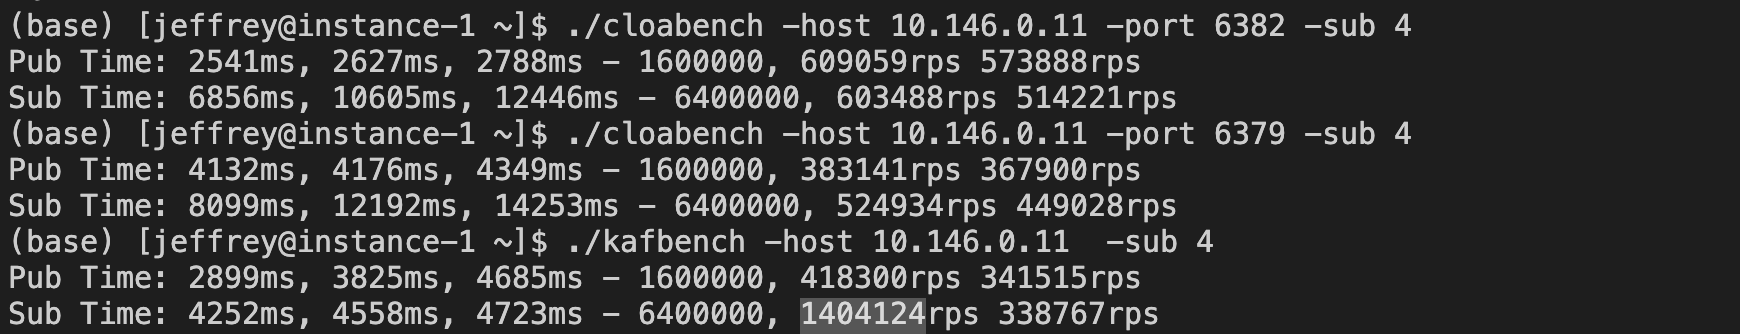

# 4_4_4

In [71]:
import re

In [72]:
cloa_pub = """
Pub Time: 1663ms, 1835ms, 1904ms - 1600000, 871934rps 840336rps
Pub Time: 2109ms, 2246ms, 2376ms - 1600000, 712377rps 673400rps
Pub Time: 2140ms, 2209ms, 2308ms - 1600000, 724309rps 693240rps
Pub Time: 1865ms, 1970ms, 2024ms - 1600000, 812182rps 790513rps
Pub Time: 2188ms, 2287ms, 2432ms - 1600000, 699606rps 657894rps
Pub Time: 2020ms, 2142ms, 2258ms - 1600000, 746965rps 708591rps
Pub Time: 1820ms, 1906ms, 1981ms - 1600000, 839454rps 807672rps
Pub Time: 2178ms, 2276ms, 2379ms - 1600000, 702987rps 672551rps
Pub Time: 1739ms, 1846ms, 1891ms - 1600000, 866738rps 846113rps
Pub Time: 1937ms, 1974ms, 2026ms - 1600000, 810536rps 789733rps
"""

In [73]:
cloa_sub = """
Sub Time: 2271ms, 2345ms, 2406ms - 6400000, 2729211rps 2660016rps
Sub Time: 5248ms, 5345ms, 5453ms - 6965814, 1303239rps 1277427rps
Sub Time: 2340ms, 2431ms, 2479ms - 6400000, 2632661rps 2581686rps
Sub Time: 1993ms, 4526ms, 5529ms - 7084126, 1565206rps 1281267rps
Sub Time: 2300ms, 2358ms, 2392ms - 6400000, 2714164rps 2675585rps
"""

In [74]:
redis_pub = """
Pub Time: 2220ms, 2300ms, 2342ms - 1600000, 695652rps 683176rps
Pub Time: 2276ms, 2299ms, 2322ms - 1600000, 695954rps 689061rps
Pub Time: 2246ms, 2307ms, 2338ms - 1600000, 693541rps 684345rps
Pub Time: 2311ms, 2350ms, 2374ms - 1600000, 680851rps 673967rps
Pub Time: 2316ms, 2347ms, 2371ms - 1600000, 681721rps 674820rps
Pub Time: 2286ms, 2335ms, 2390ms - 1600000, 685224rps 669456rps
Pub Time: 2246ms, 2317ms, 2346ms - 1600000, 690548rps 682011rps
Pub Time: 2295ms, 2329ms, 2346ms - 1600000, 686990rps 682011rps
"""

In [75]:
redis_sub = """
Sub Time: 4012ms, 4093ms, 4159ms - 6400000, 1563645rps 1538831rps
Sub Time: 7024ms, 7095ms, 7189ms - 6511184, 917714rps 905714rps
Sub Time: 3984ms, 4070ms, 4129ms - 6400000, 1572481rps 1550012rps
Sub Time: 7056ms, 7099ms, 7133ms - 6444932, 907864rps 903537rps
Sub Time: 3990ms, 4074ms, 4129ms - 6400000, 1570937rps 1550012rps
"""

In [76]:
kafka_pub = """
Pub Time: 1567ms, 1940ms, 2058ms - 1600000, 824742rps 777453rps
Pub Time: 1652ms, 1899ms, 2061ms - 1600000, 842548rps 776322rps
Pub Time: 1585ms, 1926ms, 2092ms - 1600000, 830737rps 764818rps
Pub Time: 1705ms, 1998ms, 2119ms - 1600000, 800800rps 755073rps
Pub Time: 1642ms, 1951ms, 2078ms - 1600000, 820092rps 769971rps
Pub Time: 1681ms, 1915ms, 2076ms - 1600000, 835509rps 770712rps
Pub Time: 963ms, 1769ms, 2042ms - 1600000, 904465rps 783545rps
Pub Time: 1441ms, 1887ms, 2061ms - 1600000, 847906rps 776322rps
"""

In [77]:
kafka_sub = """
Sub Time: 2412 ms, 2591 ms, 2729 ms - 6400000, 2470088rps 0rps
Sub Time: 5084 ms, 5268 ms, 5819 ms - 7863388, 1492670rps 0rps
Sub Time: 2258 ms, 2565 ms, 2757 ms - 6400000, 2495126rps 0rps
Sub Time: 5101 ms, 5297 ms, 5705 ms - 7418030, 1400420rps 0rps
Sub Time: 2160 ms, 2511 ms, 2735 ms - 6400000, 2548785rps 0rps
"""

In [78]:
def compute_avg(result_str):
    tmp = re.findall("[0-9]*rps [0-9]*rps", result_str)
    count = 0
    sum_ = 0
    
    for set_ in tmp:
        count += 1
        avg_, max_ = set_.split(" ")
        sum_ += int(avg_[:-3])
    
    return sum_ / count

In [79]:
cloa_e2e_latency = [0.199]
redis_e2e_latency = [0.18]
kafka_e2e_latency = [1.19]

cloa_throughput = [compute_avg(cloa_pub) , compute_avg(cloa_sub)]
redis_throughput = [compute_avg(redis_pub) , compute_avg(redis_sub)]
kafka_throughput = [compute_avg(kafka_pub) , compute_avg(kafka_sub)]

In [80]:
cloa_throughput

[778708.8, 2188896.2]

In [81]:
kafka_throughput

[838349.875, 2081417.8]

In [82]:
redis_throughput

[688810.125, 1306528.2]

In [83]:
import matplotlib.pyplot as plt

In [84]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

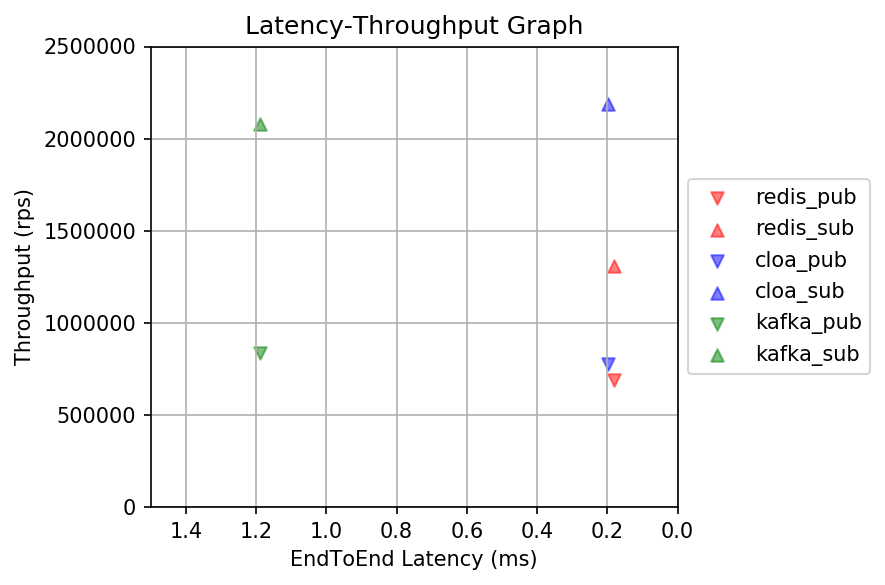

In [85]:
fig, ax = plt.subplots()
ax.scatter(redis_e2e_latency[0],redis_throughput[0], label = "redis_pub",  color= "red", alpha = 0.5, marker = 'v')
ax.scatter(redis_e2e_latency[0],redis_throughput[1], label = "redis_sub", color= "red", alpha = 0.5, marker = '^')


ax.scatter(cloa_e2e_latency[0],cloa_throughput[0], label = "cloa_pub", color = "blue", alpha = 0.5, marker = 'v')
ax.scatter(cloa_e2e_latency[0],cloa_throughput[1], label = "cloa_sub", color = "blue", alpha = 0.5, marker = '^')

ax.scatter(kafka_e2e_latency[0],kafka_throughput[0], label = "kafka_pub", color = "green", alpha = 0.5, marker = 'v')
ax.scatter(kafka_e2e_latency[0],kafka_throughput[1], label = "kafka_sub", color = "green", alpha = 0.5, marker = '^')


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("EndToEnd Latency (ms)")
ax.set_ylabel("Throughput (rps)")
ax.set_title("Latency-Throughput Graph")
ax.grid()
ax.set_xlim(1.5,0)
ax.set_ylim(0, 2500000)
plt.tight_layout()
plt.savefig("pub_4_chan_4_sub_4.png")
plt.show()


# 4_4_1

In [101]:
import re

In [102]:
cloa_pub = """
Pub Time: 1926ms, 1982ms, 2055ms - 1600000, 807265rps 778588rps
Pub Time: 1848ms, 1980ms, 2129ms - 1600000, 808080rps 751526rps
Pub Time: 1826ms, 1967ms, 2066ms - 1600000, 813421rps 774443rps
Pub Time: 1879ms, 1986ms, 2126ms - 1600000, 805639rps 752587rps
Pub Time: 1760ms, 1870ms, 1946ms - 1600000, 855614rps 822199rps
Pub Time: 1673ms, 1805ms, 1916ms - 1600000, 886426rps 835073rps
Pub Time: 1798ms, 1863ms, 1919ms - 1600000, 858829rps 833767rps
Pub Time: 1708ms, 1846ms, 1935ms - 1600000, 866738rps 826873rps
"""

In [103]:
cloa_sub = """
Sub Time: 2087ms, 2126ms, 2172ms - 1600000, 752587rps 736648rps
Sub Time: 2037ms, 2059ms, 2079ms - 1600000, 777076rps 769600rps
Sub Time: 1982ms, 2086ms, 2129ms - 1600000, 767018rps 751526rps
Sub Time: 1954ms, 2032ms, 2069ms - 1600000, 787401rps 773320rps
Sub Time: 2045ms, 2085ms, 2125ms - 1600000, 767386rps 752941rps
"""

In [104]:
redis_pub = """
Pub Time: 2767ms, 2821ms, 2860ms - 1600000, 567174rps 559440rps
Pub Time: 2731ms, 2797ms, 2835ms - 1600000, 572041rps 564373rps
Pub Time: 2701ms, 2760ms, 2784ms - 1600000, 579710rps 574712rps
Pub Time: 2724ms, 2758ms, 2778ms - 1600000, 580130rps 575953rps
Pub Time: 2693ms, 2753ms, 2776ms - 1600000, 581184rps 576368rps
Pub Time: 2292ms, 2327ms, 2341ms - 1600000, 687580rps 683468rps
Pub Time: 2309ms, 2348ms, 2366ms - 1600000, 681431rps 676246rps
Pub Time: 2266ms, 2322ms, 2347ms - 1600000, 689061rps 681721rps
Pub Time: 2320ms, 2359ms, 2378ms - 1600000, 678253rps 672834rps
"""

In [105]:
redis_sub = """
Sub Time: 2841ms, 2907ms, 2944ms - 1600000, 550395rps 543478rps
Sub Time: 2832ms, 2886ms, 2908ms - 1600000, 554400rps 550206rps
Sub Time: 2814ms, 2857ms, 2877ms - 1600000, 560028rps 556134rps
Sub Time: 2812ms, 2854ms, 2880ms - 1600000, 560616rps 555555rps
Sub Time: 2835ms, 2861ms, 2874ms - 1600000, 559245rps 556715rps
"""

In [106]:
kafka_pub = """
Pub Time: 1544 ms, 1972 ms, 2072 ms - 1600000, 811359rps 772200rps
Pub Time: 1303 ms, 1936 ms, 2060 ms - 1600000, 826446rps 776699rps
Pub Time: 1609 ms, 1921 ms, 2073 ms - 1600000, 832899rps 771828rps
Pub Time: 1056 ms, 1889 ms, 2070 ms - 1600000, 847008rps 772946rps
Pub Time: 1815 ms, 2033 ms, 2100 ms - 1600000, 787014rps 761904rps
Pub Time: 1698 ms, 1943 ms, 2076 ms - 1600000, 823468rps 770712rps
Pub Time: 1522 ms, 1951 ms, 2080 ms - 1600000, 820092rps 769230rps
Pub Time: 1484 ms, 1912 ms, 2083 ms - 1600000, 836820rps 768122rps
Pub Time: 1731 ms, 1986 ms, 2124 ms - 1600000, 805639rps 753295rps
Pub Time: 1543 ms, 1953 ms, 2092 ms - 1600000, 819252rps 764818rps
Pub Time: 1704 ms, 2053 ms, 2134 ms - 1600000, 779347rps 749765rps
Pub Time: 1518 ms, 1886 ms, 2071 ms - 1600000, 848356rps 772573rps
Pub Time: 1367 ms, 1906 ms, 2080 ms - 1600000, 839454rps 769230rps
Pub Time: 1561 ms, 1938 ms, 2112 ms - 1600000, 825593rps 757575rps
Pub Time: 1690 ms, 1961 ms, 2091 ms - 1600000, 815910rps 765184rps
Pub Time: 1604 ms, 1961 ms, 2092 ms - 1600000, 815910rps 764818rps
Pub Time: 1769 ms, 1955 ms, 2071 ms - 1600000, 818414rps 772573rps
Pub Time: 1587 ms, 1937 ms, 2087 ms - 1600000, 826019rps 766650rps
Pub Time: 1580 ms, 1957 ms, 2083 ms - 1600000, 817577rps 768122rps
Pub Time: 1687 ms, 1951 ms, 2082 ms - 1600000, 820092rps 768491rps
"""

In [107]:
kafka_sub = """
Sub Time: 2030 ms, 2077 ms, 2110 ms - 1600000, 770341rps 0rps
Sub Time: 2039 ms, 2045 ms, 2050 ms - 1600000, 782396rps 0rps
Sub Time: 2017 ms, 2038 ms, 2058 ms - 1600000, 785083rps 0rps
Sub Time: 2030 ms, 2048 ms, 2069 ms - 1600000, 781250rps 0rps
Sub Time: 2025 ms, 2060 ms, 2084 ms - 1600000, 776699rps 0rps
"""

In [108]:
def compute_avg(result_str):
    tmp = re.findall("[0-9]*rps [0-9]*rps", result_str)
    count = 0
    sum_ = 0
    
    for set_ in tmp:
        count += 1
        avg_, max_ = set_.split(" ")
        sum_ += int(avg_[:-3])
    
    return sum_ / count

In [109]:
cloa_e2e_latency = [0.199]
redis_e2e_latency = [0.18]
kafka_e2e_latency = [1.19]

cloa_throughput = [compute_avg(cloa_pub) , compute_avg(cloa_sub)]
redis_throughput = [compute_avg(redis_pub) , compute_avg(redis_sub)]
kafka_throughput = [compute_avg(kafka_pub) , compute_avg(kafka_sub)]

In [110]:
cloa_throughput

[837751.5, 770293.6]

In [111]:
kafka_throughput

[820833.45, 779153.8]

In [112]:
redis_throughput

[624062.6666666666, 556936.8]

In [113]:
import matplotlib.pyplot as plt

In [114]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

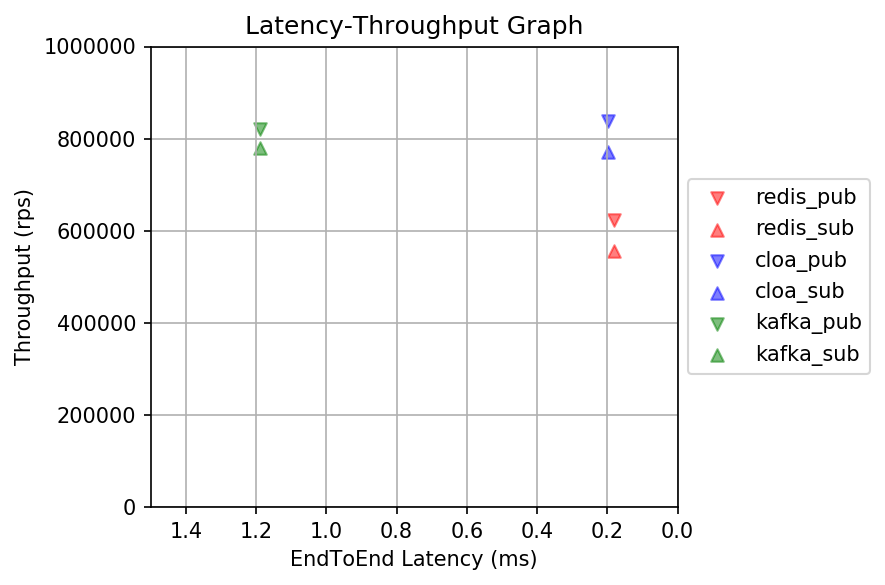

In [115]:
fig, ax = plt.subplots()
ax.scatter(redis_e2e_latency[0],redis_throughput[0], label = "redis_pub",  color= "red", alpha = 0.5, marker = 'v')
ax.scatter(redis_e2e_latency[0],redis_throughput[1], label = "redis_sub", color= "red", alpha = 0.5, marker = '^')


ax.scatter(cloa_e2e_latency[0],cloa_throughput[0], label = "cloa_pub", color = "blue", alpha = 0.5, marker = 'v')
ax.scatter(cloa_e2e_latency[0],cloa_throughput[1], label = "cloa_sub", color = "blue", alpha = 0.5, marker = '^')

ax.scatter(kafka_e2e_latency[0],kafka_throughput[0], label = "kafka_pub", color = "green", alpha = 0.5, marker = 'v')
ax.scatter(kafka_e2e_latency[0],kafka_throughput[1], label = "kafka_sub", color = "green", alpha = 0.5, marker = '^')


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("EndToEnd Latency (ms)")
ax.set_ylabel("Throughput (rps)")
ax.set_title("Latency-Throughput Graph")
ax.grid()
ax.set_xlim(1.5,0)
ax.set_ylim(0, 1000000)
plt.tight_layout()
plt.savefig("pub_4_chan_4_sub_1.png")
plt.show()
